## Weather Station

We will find pressure, humidity, temerature, precipitation, visibility, wind speed for geographical locations via pyspark streaming.  

### Choose Locations 
In this project, we decided to choose 'dn', '9m', '9x', '9q', and '9y'. These locations are in the U.S. and across from a few different states.  We use 2-bit geo-hash because it ensures the sufficiency of data.

In [1]:
import geohash
import datetime

geographical_locations = ['dn', '9m', '9x', '9q', '9y']

def parse_float(val):
    try:
        return float(val)
    except:
        return -1
    
#  surface temperature, pressure, humidity, precipitation, visibility, and wind speed
def parseLine(line):    
    variables = line.split("\t")
    try:
        lat = parse_float(variables[1])
        lon = parse_float(variables[2])
        gh = geohash.encode(lat, lon)[0:2] # gh with 2 bits
        if(gh not in geographical_locations):
            return None
        
        pressure = parse_float(variables[6])
        humidity = parse_float(variables[8])
        temperature = parse_float(variables[10])
        precipitation = parse_float(variables[13])
        visibility = parse_float(variables[15])
        wind_speed = parse_float(variables[17])
        
        return (gh, (pressure, humidity, temperature, precipitation, visibility, wind_speed))
    except:
        return None

### Update data from streaming
Recieving data will be updated by the *update_metric*, so basically we record the sum and count for each feature, and they are averaged when plotting to a figure.  

In [2]:
#existingAggregate = cnt, pressure, humidity, temerature, precipitation, visibility
def update_metric(newValues, existingAggregate):
    ((cp, pressure), 
     (ch, humidity), 
     (ct, temerature), 
     (cpre, precipitation), 
     (cv, visibility), 
     (cw, wind_speed)) = (existingAggregate or ((0,0),(0,0),(0,0),(0,0),(0,0),(0,0)))
    for newValue in newValues:
        if newValue[0] >= 0:
            cp+= 1
            pressure += newValue[0]
        if newValue[1] >= 0:
            ch += 1
            humidity += newValue[1]
        if newValue[2] >= 0:
            ct += 1
            temerature += newValue[2] 
        if newValue[3] >= 0:
            cpre += 1
            precipitation += newValue[3]
        if newValue[4] >= 0:
            cv += 1
            visibility += newValue[4]
        if newValue[5] >= 0:
            cw += 1
            wind_speed += newValue[5]
        
    return ((cp, pressure), (ch, humidity), (ct, temerature), (cpre, precipitation), (cv, visibility), (cw, wind_speed))

def cal_mean(aggregated):
    ((cp, pressure), 
     (ch, humidity), 
     (ct, temerature), 
     (cpre, precipitation), 
     (cv, visibility), 
     (cw, wind_speed)) = aggregated
    # Avoid devision by 0
    if cp == 0 : cp = 1
    if ch == 0 : ch = 1
    if ct == 0 : ct = 1
    if cpre == 0 : cpre = 1
    if cv == 0 : cv = 1
    if cw == 0 : cw = 1
    
    avg_pressure = pressure / cp
    avg_hum = humidity / ch
    avg_temp = temerature / ct
    avg_precipitation = precipitation / cpre
    avg_visibility = visibility / cv
    avg_wind_speed = wind_speed / cw
    return (avg_pressure, avg_hum, avg_temp, avg_precipitation, avg_visibility, avg_wind_speed)


### Figuring
The figure we are demonstrating contains 3 x 2 pieces. Each chuck represents a feature and its means(x-axis) for 5 locations(y-axis). We will update the figure like a small animation everytime when new incoming data is well calculated.   

In [3]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
from IPython import display

bar_color_set = ['lightsteelblue', 'cornflowerblue', 'royalblue',  'gold', 'tomato']
titles = ['Pressure', 'Humidity', 'Temerature', 'Precipitation', 'Visibility', 'Wind Speed']
xlims = [(0, 150000), (0,100), (0, 500), (0, 1), (0, 40000), (0, 10)]

def display_fig(locations, values):
    display.clear_output(wait=True)
    fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(nrows=3, ncols=2, figsize =(16,14))
    axes = [ax1, ax2, ax3, ax4, ax5, ax6]
    for i in range(6):
        ax = axes[i]
        for s in ['top', 'bottom', 'left', 'right']: 
            ax.spines[s].set_visible(False) 
        ax.barh(y=locations, width=values[i], height=0.5, color=bar_color_set) 
        ax.grid(b = True, color ='grey', linestyle ='-.', linewidth = 0.5,  alpha = 0.3) 
        ax.invert_yaxis() 
        ax.xaxis.set_ticks_position('none') 
        ax.yaxis.set_ticks_position('none')   
        ax.set_title(titles[i], loc ='left') 
        ax.set_xlim(xlims[i])
        ax.xaxis.set_tick_params(pad = 1) 
        ax.yaxis.set_tick_params(pad = 10) 
        for i in ax.patches: 
            ax.text(i.get_width()+0.3, i.get_y()+0.3,  
                str(round((i.get_width()), 2)), 
                fontsize = 12, 
                color ='black')
        
    display.display(plt.gcf())
    plt.close()

### Format RDD
After incoming data is aggregated, we have to format it before we plot into a picture. The finalized RDD is in a key-value pair where key is geo-hash, and value is 5 means for each feature. We will want to transform it to an 2-D array, where putting the  identical features together. 

In [4]:
def plot_rdd(rdd):
    pres = []
    hums = []
    temp = []
    prec = []
    visi = []
    wind = []
    metric_dict = dict(rdd.collect())
    if(len(metric_dict) < 5):
        return
    for geo in geographical_locations:
        metric = metric_dict[geo];
        pres.append(metric[0])
        hums.append(metric[1])
        temp.append(metric[2])
        prec.append(metric[3])
        visi.append(metric[4])
        wind.append(metric[5])
        
    plot_data = [pres, hums, temp, prec, visi, wind]
    display_fig(geographical_locations, plot_data)

### Dataset 
In this task, we use the 2017, 2018 and 2019 dataset of NAM without sampled because the 2015 and 2016 have some null data. 

### Start to process
And now we can enable the streaming process and wait for the incoming data. There is a multithread data emitter under the multi-thread-emitter folder. Setting up host and port(need to be the same as here), when streaming detects the data it will output it to the figure.  

### Straming logic
The spark process involves 5 steps to make the resulting figure. 
1. Parse each line and fetch the data (like humidity, temperature, etc). 
2. Filter out the rows which are not located on the 5 locations 
3. Aggregate the incoming data to existing data. 
4. Calculate means
5. Output to a figure. 

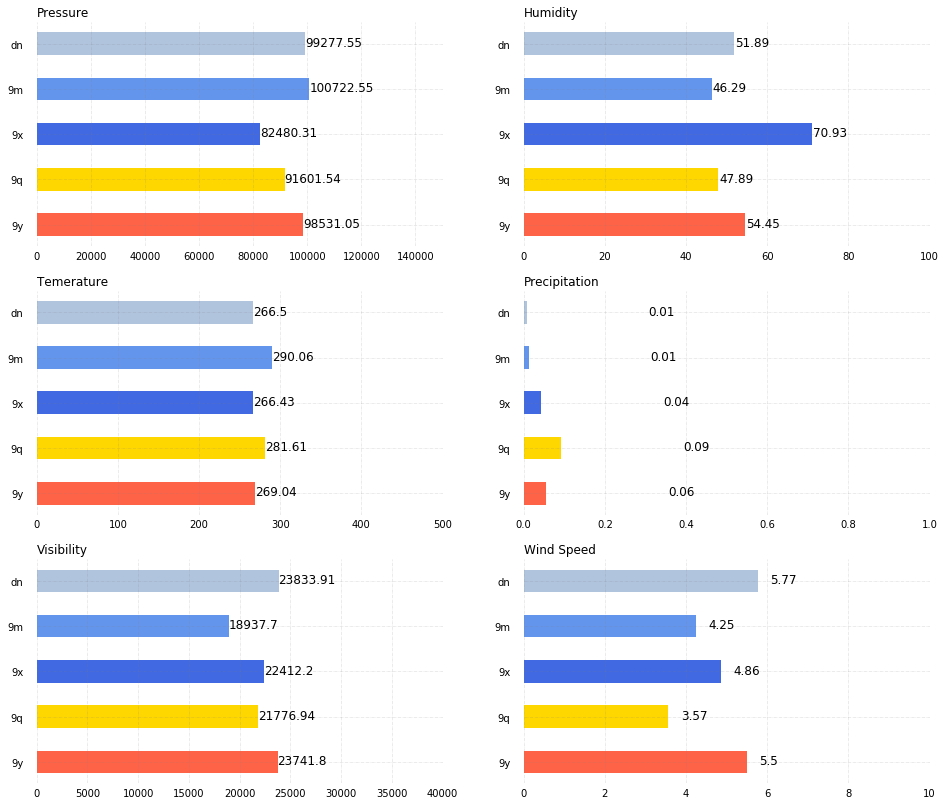

In [5]:
from pyspark.streaming import StreamingContext
ssc = StreamingContext(sc, 0.3)
ssc.checkpoint("/checkpoint")
lines = ssc.socketTextStream("orion03", 12890)
parsed_weather_info = lines.map(lambda line: parseLine(line)).filter(lambda val: val is not None) # geo -> (6 features)
updated_metric = parsed_weather_info.updateStateByKey(update_metric) # geo -> (6 features)
metric_mean = updated_metric.map(lambda val: (val[0], cal_mean(val[1]))) # (geo -> 6 feature means)
metric_mean.foreachRDD(lambda rdd: plot_rdd(rdd))
ssc.start()


### Stop the streaming process

In [ ]:
ssc.stop(stopSparkContext=False)
